# Random Forest Classifier

The goal of this notebook is to classify our samples using a RandomForest model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)


We need to identify the optimal 

In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.ensemble import RandomForestClassifier

In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g');

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [4]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train = average_speakers(train)
    
    british_df = pd.read_csv('british_mfcc.csv')
    feature_cols = [x for x in british_df.columns if 'feature' in x]
    
    return train, test, british_df[feature_cols]


train, test, british_df = load_data()

In [9]:
def fit_rf(train, test, word=None, features = None, k = None, display_conf = False):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    
    tree_counts = []
    tree_count_score = []
    
    if k is None:
        fig, ax = plt.subplots(figsize=(20,10))

        for i in np.arange(1, 150, 1):
            tree_counts.append(i)
            clf = RandomForestClassifier(n_estimators = i).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tree_count_score.append(1 - np.mean(y_pred == y_test))
            
        opt_score_idx = np.where(tree_count_score == np.amin(tree_count_score))
        opt_tree = tree_counts[opt_score_idx[0][0]]

        sns.lineplot(x=tree_counts, y=tree_count_score, ax=ax, markers=True)

        return tree_counts, tree_count_score, opt_score_idx, opt_tree
    
    clf = RandomForestClassifier(n_estimators = k).fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"Random Forest mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return conf_df, clf

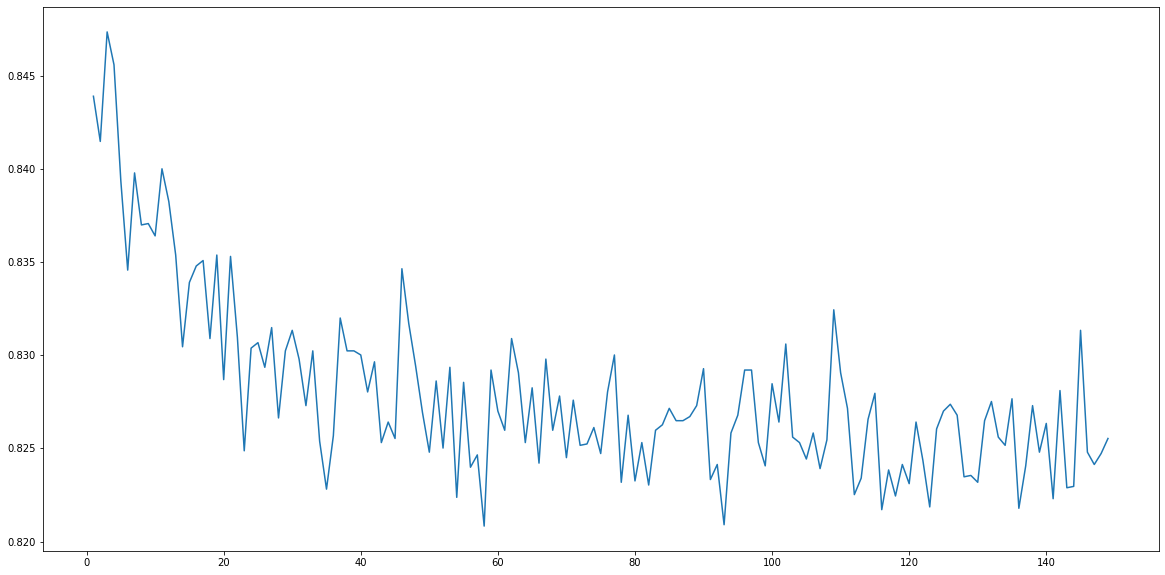

In [35]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(train, test)

In [36]:
print(f"The optimal tree count is: {opt_tree}")

The optimal tree count is: 58


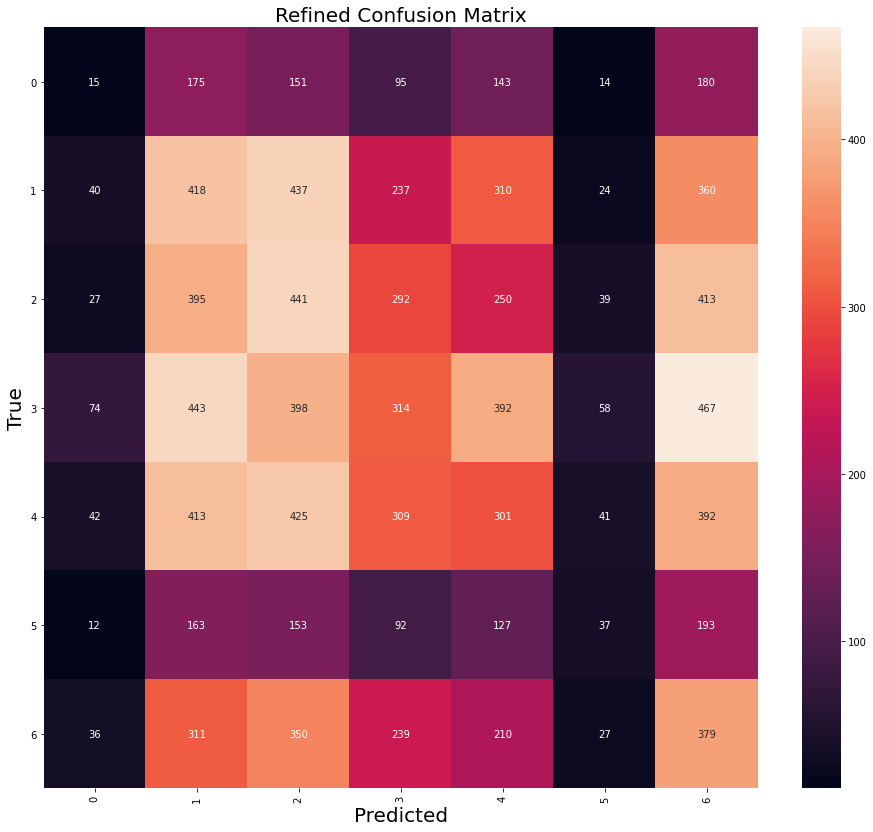

Random Forest mislabeled points out of a total 10854 points : 8949
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.060976     0.180328     0.187261     0.198986     0.173687   
recall       0.019405     0.228916     0.237480     0.146319     0.156526   
f1-score     0.029441     0.201737     0.209402     0.168636     0.164661   
support    773.000000  1826.000000  1857.000000  2146.000000  1923.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.154167     0.158977  0.175511      0.159197      0.170601  
recall       0.047619     0.244201  0.175511      0.154352      0.175511  
f1-score     0.072763     0.192581  0.175511      0.148460      0.167122  
support    777.000000  1552.000000  0.175511  10854.000000  10854.000000  


In [10]:
rf_conf, rfw_clf = fit_rf(train, test, k=58, display_conf=True)

In [16]:
british_pred = rfw_clf.predict(british_df)

whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])
whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR7    373
DR2    117
DR3    102
DR4     87
DR5     37
DR6     15
DR1      1
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,1,0.136612
DR2,117,15.983607
DR3,102,13.934426
DR4,87,11.885246
DR5,37,5.054645
DR6,15,2.049180
DR7,373,50.956284


In [12]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test

In [13]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4003
North    3376
South    1923
West     1552
Name: accent, dtype: int64

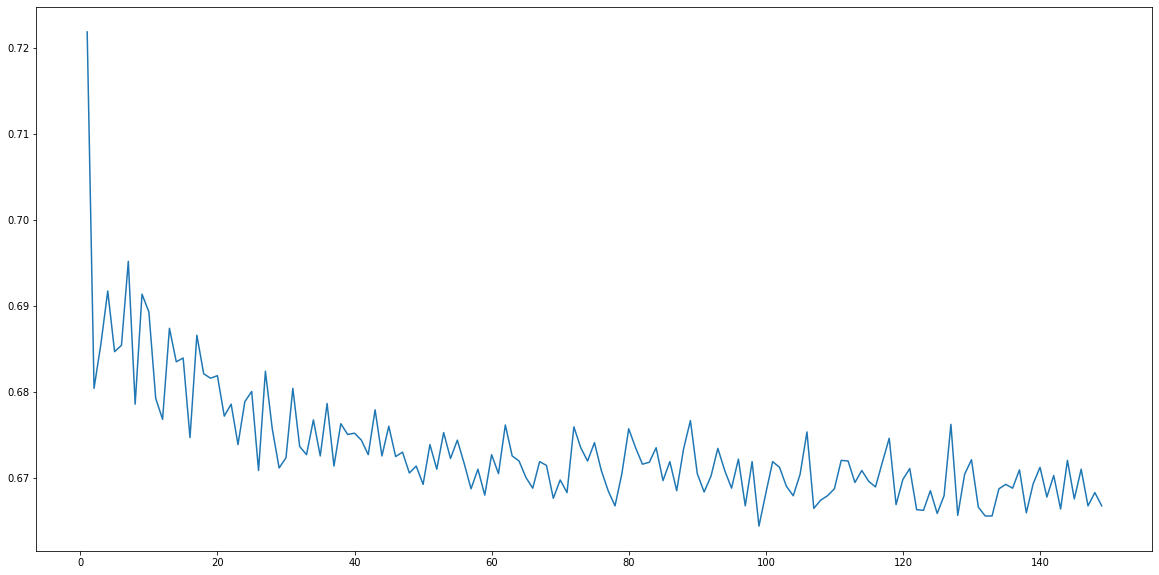

In [40]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train, condensed_test)

In [41]:
opt_tree

99

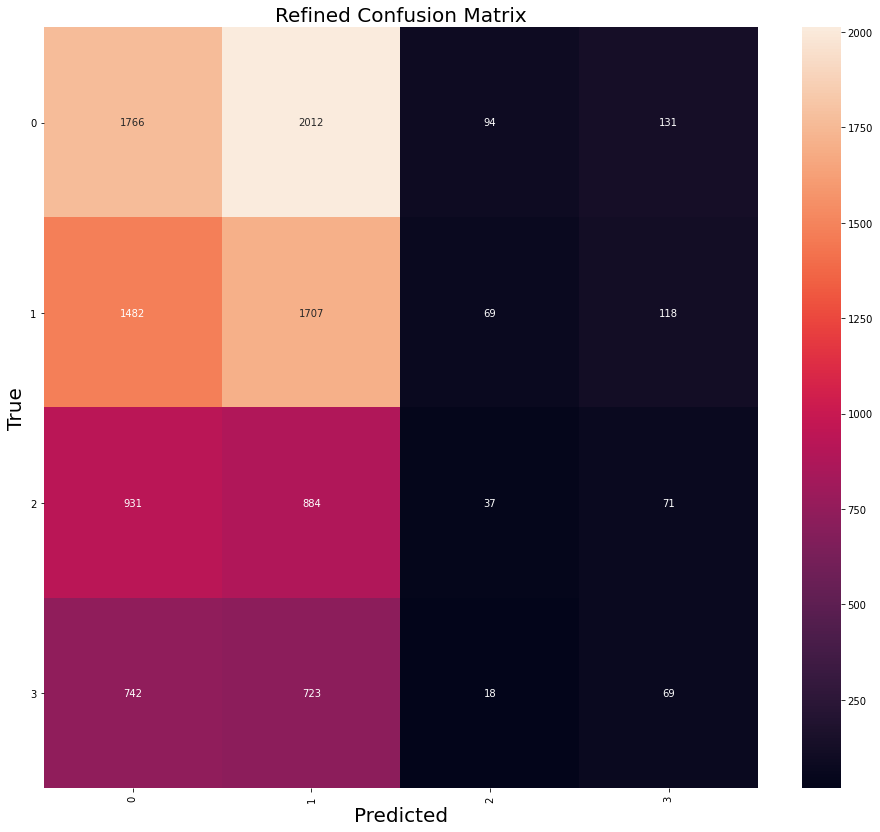

Random Forest mislabeled points out of a total 10854 points : 7275
                   Mid        North        South         West  accuracy  \
precision     0.358870     0.320503     0.169725     0.177378   0.32974   
recall        0.441169     0.505628     0.019241     0.044459   0.32974   
f1-score      0.395787     0.392324     0.034563     0.071097   0.32974   
support    4003.000000  3376.000000  1923.000000  1552.000000   0.32974   

              macro avg  weighted avg  
precision      0.256619      0.287474  
recall         0.252624      0.329740  
f1-score       0.223443      0.284285  
support    10854.000000  10854.000000  


In [14]:
rf_conf_condensed, rf_con_model = fit_rf(condensed_train, condensed_test, k=99, display_conf=True)

In [17]:
british_pred = rf_con_model.predict(british_df)



condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


North    277
West     242
Mid      208
South      5
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,208,28.415301
North,277,37.841530
South,5,0.683060
West,242,33.060109


In [18]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
West     5821
Name: accent, dtype: int64

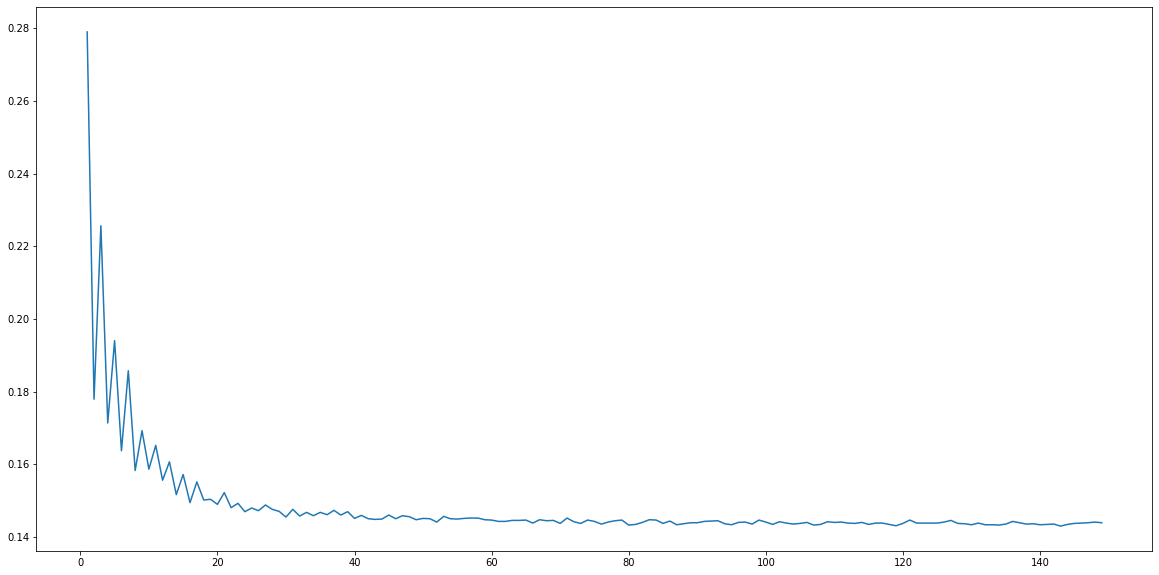

In [19]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train_two_regions, condensed_tes_two_regions)

In [20]:
opt_tree

143

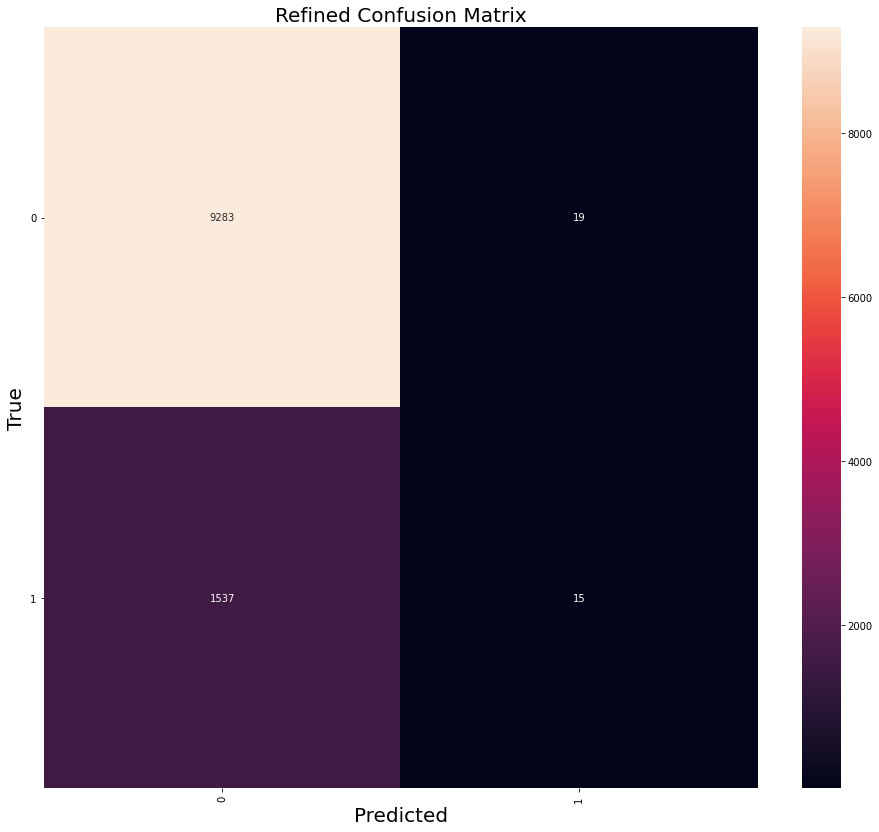

Random Forest mislabeled points out of a total 10854 points : 1556
                  East         West  accuracy     macro avg  weighted avg
precision     0.857948     0.441176  0.856643      0.649562      0.798355
recall        0.997957     0.009665  0.856643      0.503811      0.856643
f1-score      0.922672     0.018916  0.856643      0.470794      0.793445
support    9302.000000  1552.000000  0.856643  10854.000000  10854.000000


In [21]:
rf_conf_cm, rf_con_cm = fit_rf(condensed_train_two_regions, condensed_tes_two_regions, k=143, display_conf=True)

In [22]:
british_pred = rf_con_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    684
West     48
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,684,93.442623
West,48,6.557377
